#1 Environment preparation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
np.random.seed(42)

Windows (local) settings

In [3]:
#Edit this to point to project root
sep = "\\"
home = f"B:{sep}Dev{sep}GitHub{sep}University{sep}ThesisMSc{sep}StolenVehicleDetector{sep}Machine Learning{sep}OCR{sep}"
data_dir = f"{home}data{sep}"
model_dir = f"{home}model{sep}"

Linux (colab) settings

In [ ]:
sep = "/"
#Edit this to point to project root
home = f"{sep}content{sep}OCR{sep}"
data_dir = f"{home}data{sep}"
model_dir = f"{home}model{sep}"

In [4]:
#Setup project directories
if not os.path.exists(home):
    os.makedirs(home)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [5]:
characters = []

with open(data_dir + 'characters.txt', 'r') as file:
    characters = [line.strip('\n') for line in file]

print(characters)

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']


#2 Dataset

In [6]:
class AbstractDatasetLoader:
    '''Abstract dataset loader class
    '''
    dataset_name = ""
    source_url: str = ""

    def __init__(self, data_dir: str) -> None:
        self.data_dir = data_dir
        self.dataset_dir = self.data_dir + "/" + self.dataset_name
        self.image_IDs = []
        self.labels = []
        self.characters: set = set()
        self.label_max_length: int = 0

    def __download_dataset(self):
        pass

    def __extract_dataset(self):
        pass

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset properties
        '''
        print("Number of images: ", len(self.image_IDs))
        print("Number of labels: ", len(self.labels))
        print("Longest label: ", self.label_max_length)
        print("Number of unique characters: ", len(self.characters))
        print("Characters present: ", self.characters)


class CaptchaDatasetLoader(AbstractDatasetLoader):
    '''The captcha dataset loader class
    '''

    dataset_name = "captcha_images_v2"
    source_url: str = "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip"

    def __init__(self, data_dir: str) -> None:
        super().__init__(data_dir)
        self.download_file_name = self.dataset_dir + ".zip"

    def __download_dataset(self):
        download_file_path = Path(self.download_file_name)
        if not download_file_path.exists():
            #Not yet downloaded
            urllib.request.urlretrieve(self.source_url, download_file_path)

    def __extract_dataset(self):
        download_file_path = Path(self.download_file_name)
        if download_file_path.exists():
            #if the target data directory is empty, extract the zip file
            if not os.listdir(self.data_dir):
                with zipfile.ZipFile(self.download_file_name, 'r') as zip_ref:
                    zip_ref.extractall(path = self.data_dir)

    def load(self):
        '''Loads the whole dataset before working with it
        '''
        # Download & extract dataset if it has not been yet
        self.__download_dataset()
        self.__extract_dataset()

        dataset_path = Path(self.dataset_dir)
        # Get list of the images
        self.image_IDs = sorted(list(map(str, list(dataset_path.glob("*.png")))))
        # Labels of images: image names minus ".png"
        self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.image_IDs]
        # Set of distinct characters in the labels
        self.characters = sorted(set(char for label in self.labels for char in label))
        # Compute the longest label in the dataset
        self.label_max_length = max([len(label) for label in self.labels])

In [7]:
data_loader = CaptchaDatasetLoader(data_dir)
data_loader.load()
data_loader.show_info()

Number of images:  1040
Number of labels:  1040
Longest label:  5
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [8]:
def split_data(images, labels, train_ratio, shuffle=True):
    # Get the total size of the dataset
    size = len(images)
    # Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # Get the size of the training samples
    train_samples = int(size * train_ratio)
    # Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], images[indices[train_samples:]]
    x_valid, y_valid = labels[indices[:train_samples]], labels[indices[train_samples:]]

    return x_train, x_valid, y_train, y_valid

In [9]:
#Training set ratio
train_ratio = 0.9
shuffle = True

In [10]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(data_wrapper.image_IDs), np.array(data_wrapper.labels), train_ratio, shuffle)

In [72]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, characters, image_IDs, labels, image_dim=(200,200), n_channels=3, batch_size=16, shuffle=True, max_block_length=20):
        self.image_IDs = image_IDs
        self.labels = labels
        self.image_dim = image_dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_block_length = max_block_length
        self.__on_epoch_end__()

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=list(characters), num_oov_indices=0, oov_token='[?]', mask_token=' ', invert=False
        )

        # Mapping integers back to characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), num_oov_indices=1, oov_token='[?]', mask_token=' ', invert=True
        )

    def __len__(self):
        'Returns the number of full batches per epoch'
        return int(np.floor(len(self.image_IDs) / self.batch_size))

    def __data_from_indices__(self, batch_indices):
        'Generate data from indices' 
        # Initialization
        # (n_samples, *dim, n_channels)
        x = np.empty((len(batch_indices), *self.image_dim, self.n_channels))
        y = np.empty((len(batch_indices), self.max_block_length), dtype=int)
        # Generate data
        for i, idx in enumerate(batch_indices):
            # Store image and its label
            x[i], y[i] = self.encode_data(self.image_IDs[idx], self.labels[idx])
        return x, y

    def __generate_batch_data__(self, index):
        'Retrieve one batch of data'
        # Indices of the current batch
        start_idx = index * self.batch_size
        end_idx = (index+1) * self.batch_size
        batch_indices = self.indices[start_idx : end_idx]
        # Generate data
        x, y = self.__data_from_indices__(batch_indices)
        return x, y

    def __call__(self):
        if(self.cntr >= self.__len__()):
            self.__on_epoch_end__()
        x, y = self.__generate_batch_data__(self.cntr)
        self.cntr += 1
        yield x, y

    def __on_epoch_end__(self):
        'Update indices after the epoch'
        self.cntr = 0
        self.indices = np.arange(len(self.image_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def encode_data(self, img_path, label):
        # Read the image
        img = tf.io.read_file(img_path)
        # Decode and convert to have the required amount of channels
        img = tf.io.decode_png(img, channels=self.n_channels)
        # Convert to float32 in [0, 1) range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # Resize to the desired size
        img = tf.image.resize_with_pad(img, self.image_dim[0], self.image_dim[1])
        # Map the characters in a block to numbers
        label = label.ljust(self.max_block_length)[0:self.max_block_length]
        label = tf.strings.unicode_split(label, input_encoding="UTF-8")
        label_encoded = self.char_to_num(label)
        # Return the results
        return img, label_encoded

    def decode_image(self, encoded_image):
        image = (encoded_image * 255).numpy().astype("uint8")
        return image

    def decode_label(self, encoded_label):
        char_block = self.num_to_char(encoded_label)
        decoded_char_block = tf.strings.reduce_join(char_block).numpy().decode("utf-8").replace(' ', '')
        return decoded_char_block

In [73]:
#Required input image dimensions (N x N images)
img_n = 200
#3 means RGB, 1 means grayscale
n_channels = 1

In [74]:
#Batch size for training and validation
batch_size = 8
characters = data_wrapper.characters
#number of characters in the dataset
num_characters = len(data_wrapper.characters)
max_block_length = 20

In [75]:
train_generator = DataGenerator(characters, x_train, x_valid, image_dim=(img_n, img_n), n_channels=n_channels, 
    batch_size=batch_size, shuffle=True, max_block_length=max_block_length)
validation_generator = DataGenerator(characters, y_train, y_valid, image_dim=(img_n, img_n), n_channels=n_channels, 
    batch_size=batch_size, shuffle=False, max_block_length=max_block_length)

In [76]:
for batch in train_generator():
    print(batch[1])

[[17 10 10  9 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 19  9  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17  6 11  5 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  7  2  3  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [16  9 14  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  9 18  5 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 18  2  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3 12 19  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [77]:
image, encoded_label = train_generator.encode_data(data_dir + "\\captcha_images_v2\\4nnf3.png", "can you feel 1a the 23456 love tonight??")
print(encoded_label)
decoded_label = train_generator.decode_label(encoded_label)
print(decoded_label)

tf.Tensor([ 9 -1 15  0 19 -1 -1  0 12 11 11 -1  0 -1 -1  0 -1 -1 11  0], shape=(20,), dtype=int64)
c[?]ny[?][?]fee[?][?][?][?][?]e


In [80]:
def data_to_dict(image, label):
    # Return a dict
    return {"image": image, "label": label}

In [81]:
train_dataset = tf.data.Dataset.from_generator(train_generator,
output_signature=(
tf.TensorSpec(shape=(batch_size, img_n, img_n, n_channels), dtype=tf.float32),
tf.TensorSpec(shape=(batch_size, max_block_length), dtype=tf.int32)))
train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = (
    train_dataset.map(data_to_dict, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_generator(validation_generator,
output_signature=(
tf.TensorSpec(shape=(batch_size, img_n, img_n, n_channels), dtype=tf.float32),
tf.TensorSpec(shape=(batch_size, max_block_length), dtype=tf.int32)))
validation_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = (
    validation_dataset.map(data_to_dict, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)

In [84]:
def show_dataset_sample(dataset, generator):
    batch_size = generator.batch_size
    img_in_line = 4
    num_lines = batch_size//img_in_line
    img_size = 4
    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size, num_lines*img_size))
    for batch in dataset.take(1):
        images = batch['image']
        labels = batch['label']
        for i in range(batch_size):
            img = generator.decode_image(images[i])
            label = generator.decode_label(labels[i])
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)
    plt.show()

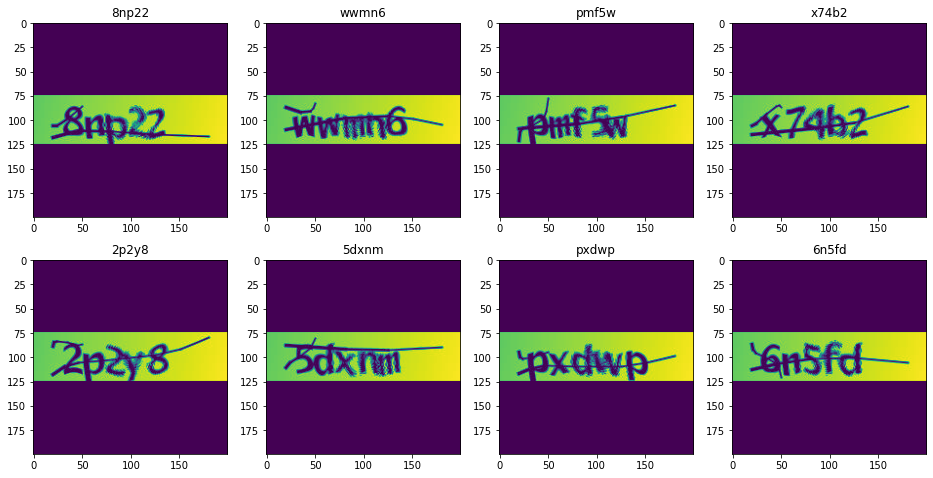

In [85]:
show_dataset_sample(train_dataset, train_generator)

In [86]:
class CTCLayer(layers.Layer):
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        #Compute the training time loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        #Add it to the parent layer
        self.add_loss(loss)

        #At test time, just return the computed predictions
        return y_pred

In [87]:
def dummy_model(img_n: int, channels: int, num_characters: int, optimizer):
    #Factor by which the image is going to be downsampled by the convolutional blocks.
    #Two convolutional blocks are used; each block has a pooling layer which downsample the features by a factor of 2.
    #So the total downsampling factor is (2x2)=4.
    downsample_factor = 2
    #Model inputs
    input_image = layers.Input(shape=(img_n, img_n, channels), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    #1st conv block
    x = layers.Conv2D(16, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_image)
    #1st max pooling
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

    # Two max pool have been used with pool size and strides 2.
    # This way, the downsampled feature maps are 4x smaller. 
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the features to the RNN part.
    new_shape = ((img_n // downsample_factor), (img_n // downsample_factor) * 16)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    x = layers.Dense(16, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2, name="Dropout")(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="Recurrent1")(x)

    # Output layer
    # +1 is for the empty character
    x = layers.Dense(num_characters + 1, activation="softmax", name="Dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTCloss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image, labels], outputs=output, name="dummy_model")
    # Optimizer
    optimizer = optimizer
    # Compile the model
    model.compile(optimizer=optimizer)
    #Return the model to use
    return model

In [88]:
def ocr_model_v1(img_n: int, channels: int, num_characters: int, optimizer):
    #Factor by which the image is going to be downsampled by the convolutional blocks.
    #Two convolutional blocks are used; each block has a pooling layer which downsample the features by a factor of 2.
    #So the total downsampling factor is (2x2)=4.
    downsample_factor = 4
    #Model inputs
    input_image = layers.Input(shape=(img_n, img_n, channels), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    #1st conv block
    x = layers.Conv2D(32, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_image)
    #1st max pooling
    x = layers.MaxPooling2D((2, 2), name="MaxPool1")(x)

    #2nd conv block
    x = layers.Conv2D(64, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    #2nd max pooling
    x = layers.MaxPooling2D((2, 2), name="MaxPool2")(x)

    # Two max pool have been used with pool size and strides 2.
    # This way, the downsampled feature maps are 4x smaller. 
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the features to the RNN part.
    new_shape = ((img_n // downsample_factor), (img_n // downsample_factor) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    # +1 is for the empty character
    x = layers.Dense(num_characters + 1, activation="softmax", name="Dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTCloss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    optimizer = optimizer
    # Compile the model
    model.compile(optimizer=optimizer)
    #Return the model to use
    return model

In [89]:
# Create the model
optimizer = keras.optimizers.Adam()
model = dummy_model(img_n, n_channels, num_characters, optimizer)
model.summary()

Model: "dummy_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 16) 160         image[0][0]                      
__________________________________________________________________________________________________
Pool1 (MaxPooling2D)            (None, 100, 100, 16) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
Reshape (Reshape)               (None, 100, 1600)    0           Pool1[0][0]                      
________________________________________________________________________________________

In [90]:
epochs = 10
early_stopping_patience = 3

#Early stopping configuration
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [ ]:
#Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)